# Modelling discharge at Mohembo using uppercatchment rainfall


* **Products used:** 
ERA5

## Description

The discharge data at Mohembo becomes much more sparse during the era of good quality satellite observations, making it unreliable for comparing discharge with surface water extent. This notebook will try to model the discharge at Mohembo using the upstream rainfall extracted from ERA5 in a previous notebook

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.load_era5 import load_era5


/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
warnings.filterwarnings("ignore")

## Analysis Parameters

In [3]:
upstream_rainfall_1989_2009 = 'results/upstream_rainfall_daily_1989-01_to_2009-12.csv'

upstream_rainfall_2010_2021 = 'results/upstream_rainfall_daily_2010-01_to_2021-05-26.csv'

freq='Q-DEC'

max_lags = 3

## Retrieve historical rainfall data over all areas of interest

This data has already been retrieved from ERA5 so we can simply pull in the csv on disk

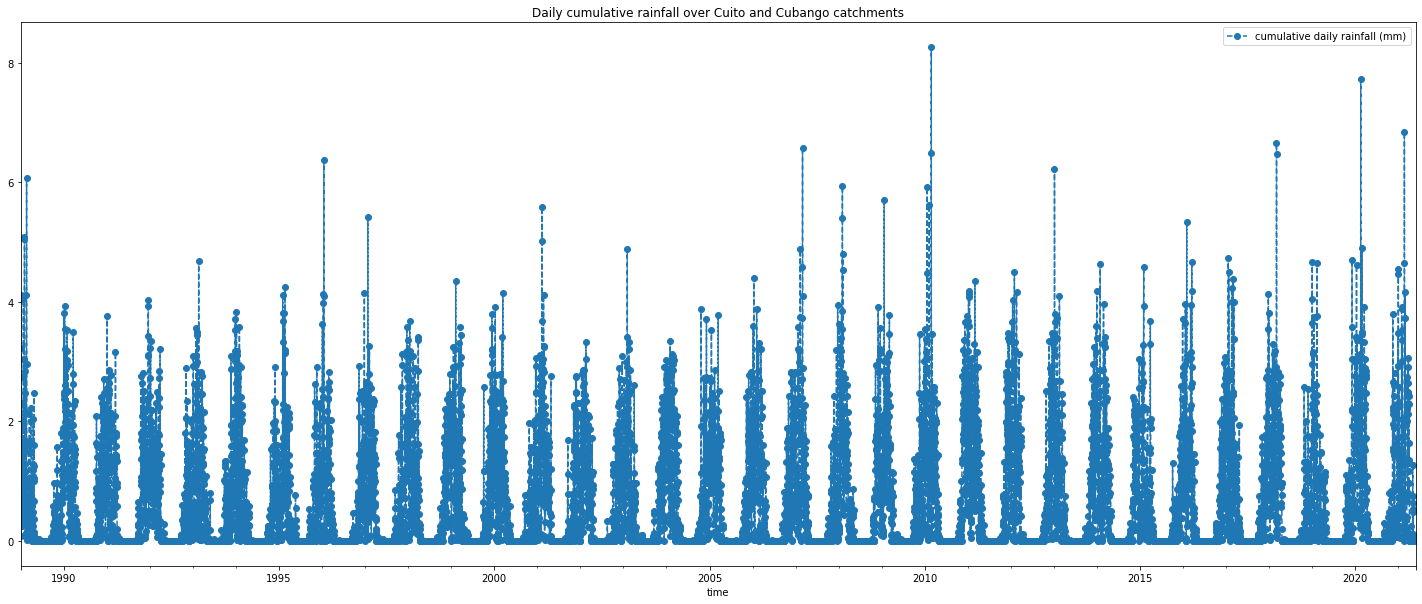

In [4]:
upstream_rainfall_1989_2009 = pd.read_csv(upstream_rainfall_1989_2009, index_col='time',parse_dates=True)
upstream_rainfall_2010_2021 = pd.read_csv(upstream_rainfall_2010_2021, index_col='time',parse_dates=True)
rain = pd.concat([upstream_rainfall_1989_2009, upstream_rainfall_2010_2021])
rain.plot(figsize=(25,10), marker='o', linestyle='dashed')
plt.title('Daily cumulative rainfall over Cuito and Cubango catchments');

#### Code block that loads rainfall from ERA5

In [5]:
# # Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f
# vector_file = 'data/OB_FWR_Hydrography_Okavango_Subasins_polygon.geojson'

# # define time period of interest
# time_range = '1989-01', '2009-12'

# # load basin polygons
# # Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f-caee3d756da9
# basin = gpd.read_file(vector_file)

# # upstream include Cuito and Cubango subbasins
# upstream = basin[basin.Subbasin.isin(['Cuito', 'Cubango'])]
# print(upstream)

# # get historical rainfall for upstream and delta
# bounds = upstream.total_bounds
# lat = bounds[1], bounds[3]
# lon = bounds[0], bounds[2]

# # download ERA5 rainfall and aggregate to monthly
# var = 'precipitation_amount_1hour_Accumulation'
# precip = load_era5(var, lat, lon, time_range, reduce_func=np.sum, resample='1D').compute()

# # fix inconsistency in axis names
# precip = precip.rename({'lat':'latitude', 'lon':'longitude'})

# upstream_raster = xr_rasterize(upstream, precip, x_dim='longitude', y_dim='latitude')

# upstream_rainfall = precip[var].where(upstream_raster).sum(['latitude','longitude'])

# upstream_rainfall.to_dataframe().drop('spatial_ref',axis=1).rename({'precipitation_amount_1hour_Accumulation':'cumulative daily rainfall (mm)'},axis=1).to_csv(f'results/upstream_rainfall_daily_{time_range[0]}_to_{time_range[1]}.csv')

## Import discharge data

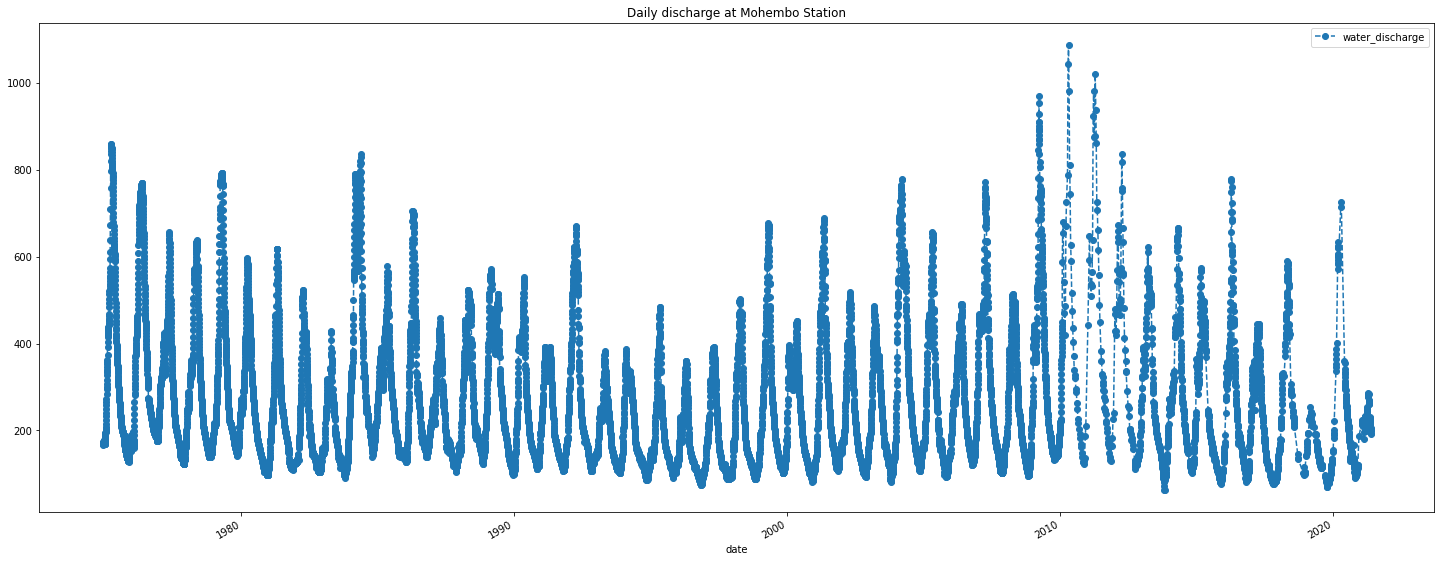

In [6]:
discharge = 'data/mohembo_daily_water_discharge_data.csv'
dis=pd.read_csv(discharge)
dis['date'] = pd.to_datetime(dis['date'], dayfirst=True)
dis = dis.set_index('date')

dis.plot(figsize=(25,10),  marker='o', linestyle='dashed')
plt.title('Daily discharge at Mohembo Station');

### Match discharge with rainfall


In [7]:
dis = dis.loc[(dis.index >= rain.index[0])]

In [8]:
df = rain.join(dis, how='outer')
df.tail()

,cumulative daily rainfall (mm),water_discharge
2021-05-22,0.0,201.356
2021-05-23,0.0,202.850
2021-05-24,0.0,200.148
2021-05-25,0.0,192.258
2021-05-26,0.0,193.073


### Resample seasonal or monthly cumulative totals

By intergrating rainfall over a longer time-period (months to seasons) we can better correlate cumulative upstream rainfall with discharge at Mohembo.

In [9]:
#total rainfall per month
df = df.resample(freq).sum()
df.head()

# rain = df['cumulative daily rainfall (mm)'].resample(freq).sum()
# discharge = df['water_discharge'].resample(freq).mean()
# df = rain.to_frame().join(discharge, how='inner')
# df.head()

,cumulative daily rainfall (mm),water_discharge
1989-03-31,114.574218,41274.290
1989-06-30,22.230042,38089.340
1989-09-30,0.119446,20520.900
1989-12-31,37.682495,11343.479
1990-03-31,137.858338,24604.860


Split dataset at 2010. That way we can build a model on the historical, complete dataset, and the predict on the incomplete record from 2010 onwards

In [10]:
df_2010 = df.loc[(df.index >= pd.to_datetime('2010-01-01'))]
df_1989 = df.loc[(df.index < pd.to_datetime('2010-01-01'))]
df_1989.tail()

,cumulative daily rainfall (mm),water_discharge
2008-12-31,95.044922,12850.7990
2009-03-31,125.729308,45340.2135
2009-06-30,6.483582,49117.4010
2009-09-30,1.598633,18477.3465
2009-12-31,82.677734,13901.3405


## Explore correlations with lags in rainfall

In [11]:
def crosscorr(datay, datax, lag=0):
    """ 
    Lag-N cross correlation. 
    
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    """
    return datay.corr(datax.shift(lag))    

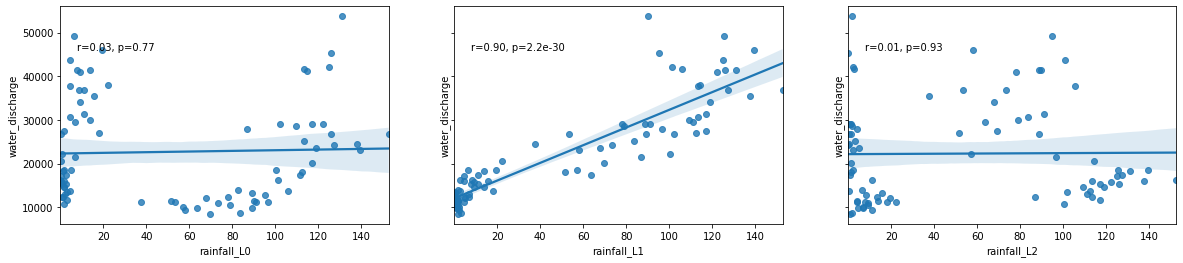

In [12]:
# calculate cross correlation for each lag period
xcov = [crosscorr(df_1989['water_discharge'], df_1989['cumulative daily rainfall (mm)'], lag=i) for i in range(max_lags)]

# Scatter plots of the relationship between rainfall and discharge at each lag
fig, ax = plt.subplots(1,max_lags, figsize=(20,4), sharey=True)
for lag in range(max_lags):
    df_1989['rainfall_L'+str(lag)] = df_1989['cumulative daily rainfall (mm)'].shift(lag)
    sns.regplot(x='rainfall_L'+str(lag), y='water_discharge', data=df_1989, ax=ax[lag])
    r, p = stats.pearsonr(df_1989['rainfall_L'+str(lag)][lag:], df_1989['water_discharge'][lag:])
    ax[lag].text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax[lag].transAxes)

## Linear modelling

Linearly model the relationship between rainfall and discharge using the lag that corresponds with the highest correlation

Conduct a test/train split first to get an idea of the general accuracy of this approach

In [13]:
max_value = max(xcov)
best_lag = xcov.index(max_value)
print("Best lag:",best_lag)

Best lag: 1


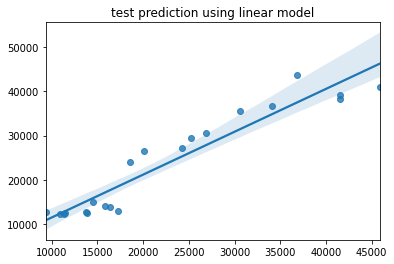

In [14]:
#convert data into a format that scikit learn likes
X = df_1989['rainfall_L'+str(best_lag)][best_lag:].values.reshape(-1,1)
y = df_1989['water_discharge'][best_lag:].values.reshape(-1,1)

#conduct a train test split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#model the relationship using just the training data, then predict on test data
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

#plot result of test data
sns.regplot(x=y_test, y=y_pred)
# r, p = stats.pearsonr(y_test, y_pred)
# plt.annotate(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p))
plt.title('test prediction using linear model');

## Predict Discharge at Mohembo

Grab the rainfall from the period we want to predict

In [15]:
fc_rainfall=df['cumulative daily rainfall (mm)'].shift(best_lag)
X_fc = fc_rainfall[best_lag:].values.reshape(-1,1)

Make a prediction using rainfall data

In [16]:
model = LinearRegression()
model.fit(X,y) #train 1989-2010
fc = model.predict(X_fc) # predict on all data

## Plot the observed vs predicted discharge as a time series

In [17]:
df_predicted = df[best_lag:]
df_predicted['predicted_discharge'] = fc.reshape(-1)
df_predicted.head(2)

,cumulative daily rainfall (mm),water_discharge,predicted_discharge
1989-06-30,22.230042,38089.34,35264.791292
1989-09-30,0.119446,20520.90,16598.310150


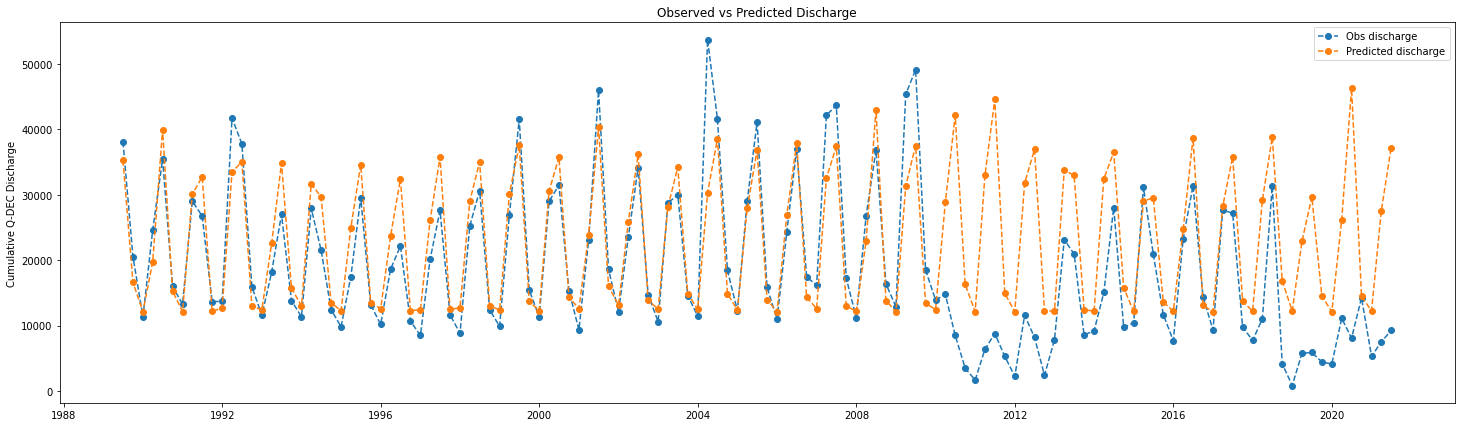

In [18]:
fig, ax = plt.subplots(figsize=(25,7))

ax.plot(df_predicted['water_discharge'], label='Obs discharge', linestyle='dashed', marker='o')
ax.plot(df_predicted['predicted_discharge'], label = 'Predicted discharge', linestyle='dashed', marker='o')
ax.legend()
plt.title('Observed vs Predicted Discharge')
ax.set_ylabel('Cumulative '+freq+' Discharge')
ax.set_xlabel('');

### Plot rainfall 

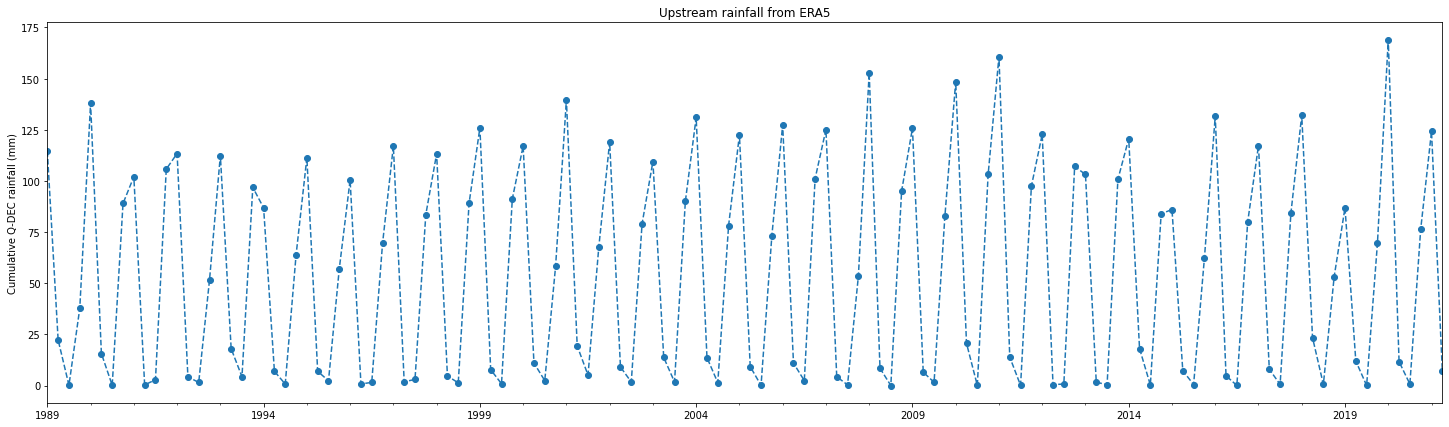

In [19]:
df['cumulative daily rainfall (mm)'].plot(linestyle='dashed', marker='o',figsize=(25,7))
plt.title('Upstream rainfall from ERA5')
plt.ylabel('Cumulative '+freq+' rainfall (mm)')
plt.xlabel('');

### Save result to disk

In [20]:
df_predicted.rename({'cumulative daily rainfall (mm)':'upstream_rainfall'}, axis=1).to_csv('results/modelled_discharge_'+freq+'.csv')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).


**Last Tested:**

In [22]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-08-09'

---
***
## Experimenting with an ARIMA model

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
p=2
d=1
q=2

In [25]:
model = ARIMA(endog=df_1989['water_discharge'], exog=df_1989['cumulative daily rainfall (mm)'], order=(p, d, q))
fit = model.fit()
# fit.summary()

### Plot the residuals of the model

                  0
count     84.000000
mean     412.089709
std     8009.796289
min   -14915.019363
25%    -3919.456487
50%     -478.555473
75%     2394.072207
max    41879.833653


<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

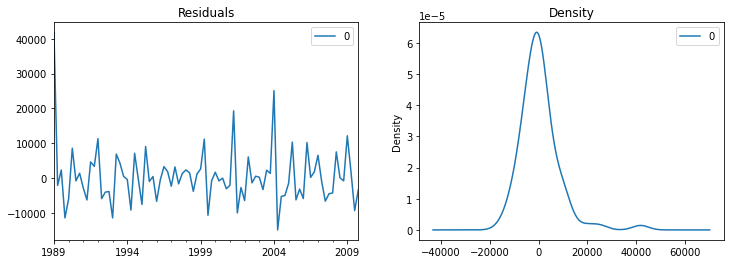

In [26]:
residuals = pd.DataFrame(fit.resid)
print(residuals.describe())
fig, ax = plt.subplots(1,2, figsize=(12,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

### Hindcast

In [27]:
start=0
end=len(df_1989)-1

hc = fit.predict(start=start, end=end, exog=df_1989['cumulative daily rainfall (mm)'], dynamic=False)

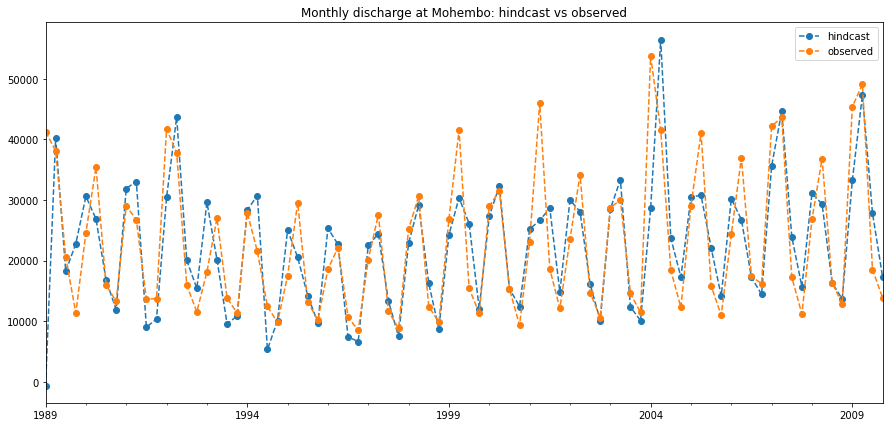

In [28]:
fig,ax = plt.subplots(1,1, figsize=(15,7))
hc.plot(ax=ax, label='hindcast',linestyle='dashed', marker='o')
df_1989['water_discharge'].plot(ax=ax, label='observed', linestyle='dashed', marker='o')
plt.title('Monthly discharge at Mohembo: hindcast vs observed')
ax.legend();

### Forecast

In [29]:
fc_len = 25

#### Load the rainfall data from the forecast period

In [30]:
fc = fit.forecast(steps=fc_len, exog=df_2010['cumulative daily rainfall (mm)'][:fc_len])

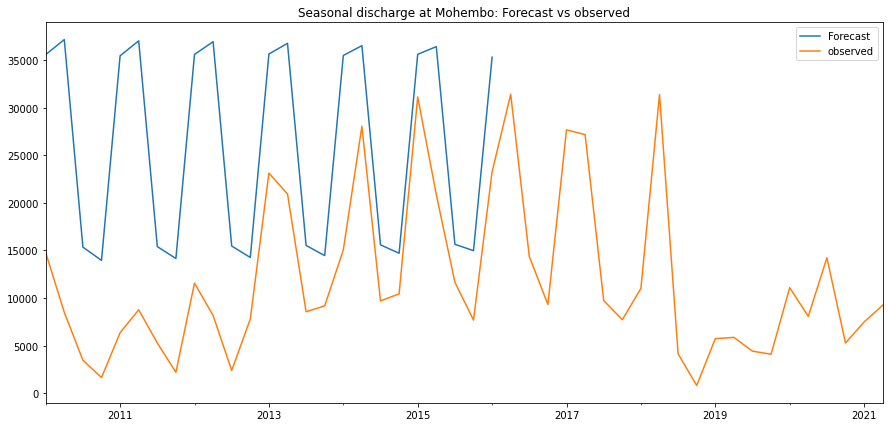

In [31]:
fig,ax = plt.subplots(1,1, figsize=(15,7))
fc.plot(ax=ax, label='Forecast')
df_2010['water_discharge'].plot(ax=ax, label='observed')
plt.title('Seasonal discharge at Mohembo: Forecast vs observed')
ax.legend();